# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
import math
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pandas.core.frame import DataFrame
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split

torch.manual_seed(20020054)

# Config

In [3]:
class Config:
  def __init__(self):
    super().__init__()

  # feature_config
    self.air_features = ['PM2.5', 'humidity', 'temperature', 'hsin', 'hcos', 'day', 'month', 'season']
    self.meteo_features = ['wind_direction', 'wind_magnitude', 'total_precipitation', 'surface_pressure', 'evaporation']
    self.features = self.air_features + self.meteo_features
    self.feature_in = len(self.features)
    self.feature_out = 1

  # split_data config
    self.split_step = 24
    self.split_in_length = 24 * 7
    self.split_out_length = 24
    self.num_src_locs = 65
    self.num_tar_locs = 6
    self.train_val_size = [200, 43]

  # feature_extractor config
    # temporal extractor config
    self.in_size_temporal_extractor = self.feature_in
    self.hidden_size_temporal_extractor = 256
    self.num_layer_temporal_extractor = 2
  
  # invert_distance_attention config
    self.in_feature_attention = self.hidden_size_temporal_extractor
    self.out_feature_attention = 1
  
  # independent_flow config
    self.in_feature_indep = self.hidden_size_temporal_extractor
    self.out_feature_indep = 24

  # dependent_flow config
    # encoder config
    self.in_size_encoder = self.hidden_size_temporal_extractor
    self.hidden_size_encoder = 64
    self.num_layer_encoder = 1
    # decoder config
    self.in_size_decoder = self.hidden_size_encoder 
    self.hidden_size_decoder = self.in_size_decoder
    self.num_layer_decoder = 1
    #
    self.in_feature_dense = self.hidden_size_decoder
    self.out_feature_dense = 1

  # training config
    self.batch_size = 16
    self.n_epochs = 20
    self.device = 'gpu'
    self.loss_function = 'mse'
    self.metrics = ['rmse', 'mdape']

  # normalization data config
    '''
    min_pm2.5: 1.0                    max_pm2.5: 499.71
    min_humidity: 10.0                max_humidity: 100.0
    min_temperature: 10.0             max_temperature: 60.0
    min_wind_magnitude: 0.00378753    max_wind_magnitude: 14.667917403800887               
    min_total_precipitation: 0.0      max_total_precipitation: 0.027269363  
    min_surface_pressure: 85340.56    max_surface_pressure: 103334.19   
    min_evaporation: -0.0008854994    max_evaporation: 0.000056827907
    '''
    self.mean = torch.tensor([1, 10, 10, 0, 0, 0, 0, 0, 0, 0.003787531473246196, 0, 85340.56, -0.0008854994])
    self.std = torch.tensor([499.71, 90, 50, 1, 1, 31, 12, 4, 1, 14.667917403800887, 0.027269363, 17993.63, 0.0009423273])

config = Config()

# Read Data

In [4]:
class Reading_Raw_Data:
  def __init__(self, air_path: str, meteo_path: str):
    self.air_data, self.air_locs = self.read_air(air_path)
    self.meteo_data, self.meteo_locs = self.read_meteo(meteo_path)

  def get(self):
    return self.air_data, self.air_locs, self.meteo_data, self.meteo_locs

  def read_air(self, dir_path: str):
    path_data = dir_path
    path_locs = dir_path + 'location_input.csv'
    
    data = {}
    for name in os.listdir(path_data):
      if 'location' in name or name == 'meteo' or 'ipynb_checkpoints' in name: continue
      data_pd = pd.read_csv(path_data + name)

      hour, hsin, hcos, day, month, season, year = self.extractTimestamps(data_pd['time'])
      data.update({
          name[0: 8]: {
            'PM2.5': data_pd['PM2.5'],
            'humidity': data_pd['humidity'],
            'temperature': data_pd['temperature'],
            'time': data_pd['time'],
            'hour': hour,
            'hsin': hsin,
            'hcos': hcos,
            'day': day,
            'month': month,
            'season': season,
            'year': year,
            'name': name,
          }
      })
    
    locs_pd = pd.read_csv(path_locs)
    locs_dict = {}
    locs = {}
    longitude = []
    latitude = []
    for i in range(len(locs_pd)):
      locs_dict.update({
        locs_pd['location'][i][0: 8] : {
            'longitude': locs_pd['longitude'][i],
            'laditude': locs_pd['latitude'][i]
        }
      })
    for loc in data.keys():
      locs.update({loc : locs_dict[loc]})
    return data, locs

  def extractDate(self, timestamp: DataFrame):
    tmp = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
    return tmp.hour, tmp.day, tmp.month, tmp.year

  def extractTimestamps(self, timestamps: DataFrame):
    hour, hsin, hcos, day, month, season, year = [], [], [], [], [], [], []
    for timestamp in timestamps:
      h, d, m, y = self.extractDate(timestamp)
      hour.append(h)
      hsin.append(math.sin(2*math.pi*h/24))
      hcos.append(math.cos(2*math.pi*h/24))
      day.append(d)
      month.append(m)
      season.append(m / 4)
      year.append(y)
    return hour, hsin, hcos, day, month, season, year

  def read_meteo(self, dir_path: str):
    path_data = dir_path
    path_locs = dir_path + 'location_meteorology.csv'
    data = {}
    for name in os.listdir(path_data):
      if name == 'location_meteorology.csv': continue
      data_pd = pd.read_csv(path_data + name)
      direction, magnitude = self.extract_wind(data_pd['u10'], data_pd['v10'])
      data.update({
          name[0: -4]:
          {
            'time': data_pd['time'],
            'u10': data_pd['u10'],
            'v10': data_pd['v10'],
            'wind_direction': self.add_meteo_data(direction),
            'wind_magnitude': self.add_meteo_data(magnitude),
            'total_precipitation': self.add_meteo_data(data_pd['total_precipitation']),
            'surface_pressure': self.add_meteo_data(data_pd['surface_pressure']),
            'evaporation': self.add_meteo_data(data_pd['evaporation']),
          }
      })

    locs_pd = pd.read_csv(path_locs)
    locs_dict = {}
    locs = {}
    longitude = []
    latitude = []
    for i in range(len(locs_pd)):
      locs_dict.update({
        locs_pd['stat_name'][i]: {
            'longitude': locs_pd['lon'][i],
            'laditude': locs_pd['lat'][i]
        }
      })
    for loc in data.keys():
      locs.update({loc : locs_dict[loc]})
    return data, locs

  def extract_wind(self, u, v):
    direction = []
    magnitude = []
    for i in range(len(u)):
      x = u[i]
      y = v[i]
      direction.append(math.atan2(y, x))
      magnitude.append(math.sqrt(y ** 2 + x ** 2))
    return direction, magnitude
  
  def add_meteo_data(self, data):
    extra_data = []
    for i in range(len(data) - 1):
      extra_data.append(data[i])
      extra_data.append(None)
      extra_data.append(None)
    extra_data = pd.DataFrame({'data': extra_data})
    extra_data['data'].interpolate(method='linear', inplace=True)
    return extra_data['data']


raw_data = Reading_Raw_Data('/content/drive/Shareddrives/air-team/data_spm/Private/air-full-handled-outliers/',
                            '/content/drive/Shareddrives/air-team/data_spm/Private/meteo/')

print(raw_data.air_data.keys())
print(raw_data.air_data['S0000457'].keys())
print(raw_data.air_data['S0000457']['PM2.5'].shape)

print()
print('-----------------------------------------------------------------------')
print()

print(raw_data.meteo_data.keys())
print(raw_data.meteo_data['station_1'].keys())
print(raw_data.meteo_data['station_1']['evaporation'].shape)

dict_keys(['S0000144', 'S0000099', 'S0000146', 'S0000148', 'S0000136', 'S0000137', 'S0000192', 'S0000171', 'S0000182', 'S0000153', 'S0000169', 'S0000189', 'S0000157', 'S0000158', 'S0000210', 'S0000304', 'S0000310', 'S0000289', 'S0000238', 'S0000264', 'S0000229', 'S0000262', 'S0000323', 'S0000331', 'S0000318', 'S0000319', 'S0000337', 'S0000336', 'S0000334', 'S0000328', 'S0000341', 'S0000347', 'S0000343', 'S0000352', 'S0000368', 'S0000339', 'S0000349', 'S0000348', 'S0000346', 'S0000399', 'S0000475', 'S0000431', 'S0000400', 'S0000397', 'S0000457', 'S0000403', 'S0000370', 'S0000538', 'S0000504', 'S0000509', 'S0000541', 'S0000508', 'S0000531', 'S0000497', 'S0000494', 'S0000553', 'S0000548', 'S0000547', 'S0000551', 'S0000554', 'S0000552', 'S0000588', 'S0000585', 'S0000636', 'S0000632', 'S0000625', 'S0000611', 'S0000630', 'S0000595', 'S0000624', 'S0000621'])
dict_keys(['PM2.5', 'humidity', 'temperature', 'time', 'hour', 'hsin', 'hcos', 'day', 'month', 'season', 'year', 'name'])
(6000,)

-----

# Preprocessing Data

In [5]:
def compute_distance(src_locs: torch.Tensor, tar_locs: torch.Tensor):
    distance = []

    for tar_loc in tar_locs:
      tar_loc = tar_loc.view(1, -1)
      sum = torch.sum((src_locs - tar_loc)**2, 1)
      dist = torch.sqrt(sum)
      normalized_dist = dist / torch.sum(dist)
      distance.append(normalized_dist)

    distance = torch.stack(distance, 0)
    return distance

## Merge Data

In [6]:
class Merge_Data:
  def __init__(self, data: torch.Tensor, config: Config):
    self.mean = config.mean
    self.std = config.std

    air_data, air_locs, meteo_data, meteo_locs = data.get()
    air_locs = self.merge_locs(air_locs)
    meteo_locs = self.merge_locs(meteo_locs)
    
    air_data = self.merge_features(air_data, config.air_features)
    meteo_data = self.merge_features(meteo_data, config.meteo_features)
    meteo_data = self.solve_meteo_feature(meteo_data, air_locs, meteo_locs)
    
    self.locs = air_locs
    self.data = air_data
    self.data = self.normalize((torch.cat((air_data, meteo_data), dim = 2)))
    
  def get(self):
    return self.data, self.locs

  def merge_features(self, data: dict, use_features: list):
    features = []
    for loc in data.keys():
      feature = []

      for feat in use_features:
        feature.append(torch.tensor(data[loc][feat]))
      
      features.append(torch.stack(feature, dim=1))
    features = torch.stack(features, dim=0)
    
    return features

  def merge_locs(self, locs: dict):
    coords = []
    for loc in locs.keys():
      coord = list(locs[loc].values())
      coords.append(torch.tensor(coord))
    locs = torch.stack(coords, dim=0)
    return locs
  
  def solve_meteo_feature(self, meteo_data: torch.Tensor, air_locs: torch.Tensor, 
                          meteo_locs: torch.Tensor, knn = 5):
    meteo_features = []
    for air_loc in air_locs:
      
      distance_id = []
      for id in range(len(meteo_locs)):
        meteo_loc = meteo_locs[id]
        distance = torch.sqrt(torch.sum((air_loc - meteo_loc) ** 2)) * 111
        distance_id.append([distance.item(), id])
      
      distance_id.sort()
      distance_id = torch.tensor(distance_id)
      
      knn_inv_dis = 1 / distance_id[0:knn, 0].view(-1, 1, 1)
      knn_id = distance_id[0:knn, 1].to(torch.long)

      knn_meteo = meteo_data[knn_id, :]
      knn_meteo = torch.sum(knn_meteo * knn_inv_dis, dim = 0)
      knn_meteo /= torch.sum(knn_inv_dis)

      meteo_features.append(knn_meteo)
    meteo_features = torch.stack(meteo_features, dim=0)
    return meteo_features

  def normalize(self, data: torch.tensor):
    return (data - self.mean) / self.std

merged_data = Merge_Data(raw_data, config)

print(merged_data.locs.shape)
print(merged_data.data.shape)
print(config.features)
print(merged_data.data[0][0])

torch.Size([71, 2])
torch.Size([71, 6000, 13])
['PM2.5', 'humidity', 'temperature', 'hsin', 'hcos', 'day', 'month', 'season', 'wind_direction', 'wind_magnitude', 'total_precipitation', 'surface_pressure', 'evaporation']
tensor([ 0.1015,  0.5832,  0.0945,  0.0000,  1.0000,  0.0323,  0.0833,  0.0625,
        -1.4249,  0.1243,  0.0000,  0.9530,  0.9268], dtype=torch.float64)


## Split Input-Output & Train-Val

In [7]:
class Split_Data:
  def __init__(self, data: torch.Tensor, config: Config):
    self.split_step = config.split_step
    self.split_in_length = config.split_in_length
    self.split_out_length = config.split_out_length
    self.batch_size = config.batch_size
    self.src_tar_size = [config.num_src_locs, config.num_tar_locs]
    self.train_val_size = config.train_val_size
    
    data, locs = data.get()
    src_data, src_locs, tar_data, tar_locs = self.split_src_tar(data, locs)
    self.distance = compute_distance(src_locs, tar_locs)

    src_data = src_data.transpose(0, 1)
    tar_data = tar_data.transpose(0, 1)

    src_data = self.split_src_data(src_data)
    tar_data = self.split_tar_data(tar_data)

    print(src_data.shape)
    print(tar_data.shape)

    self.train_set, self.val_set = self.split_train_val(src_data, tar_data)
    self.id_train_loader, self.id_val_loader = self.id_split_batch()
    
  def split_src_tar(self, data: torch.Tensor, locs: torch.Tensor):
    id = torch.arange(0, len(data))
    src_id, tar_id = random_split(id, self.src_tar_size)
    return data[src_id,:,:], locs[src_id,:], data[tar_id,:,:], locs[tar_id,:]

  def split_src_data(self, src_data: torch.tensor):
    res = []

    for i in range(0, len(src_data), self.split_step):
      end_id = i + self.split_in_length
      if end_id + self.split_out_length > len(src_data): break
      res.append(src_data[i:end_id].transpose(0, 1))

    res = torch.stack(res, dim = 0)
    return res

  def split_tar_data(self, tar_data: torch.tensor):
    res = []

    for i in range(self.split_in_length, len(tar_data), self.split_step):
      end_id = i + self.split_out_length
      if end_id > len(tar_data): break
      res.append(tar_data[i:end_id].transpose(0, 1))

    res = torch.stack(res, dim = 0)
    return res
  def split_train_val(self, src_data: torch.Tensor, tar_data: torch.Tensor):
    data_set = TensorDataset(src_data, tar_data)
    train_set, val_set = random_split(data_set, self.train_val_size)

    return train_set, val_set

  def id_split_batch(self):
    id_train_set = torch.arange(0, len(self.train_set))
    id_val_set = torch.arange(0, len(self.val_set))

    id_train_loader = DataLoader(id_train_set, batch_size=self.batch_size, shuffle=True)
    id_val_loader = DataLoader(id_val_set, batch_size=self.batch_size, shuffle=True)

    return id_train_loader, id_val_loader

  def get_in_out(self, id: torch.Tensor, tar_loc: int, name: str):
    if name == 'train': data_set = self.train_set
    else: data_set = self.val_set
    
    static_data = self.distance[tar_loc]
    temporal_data, output = data_set[list(id)]
    
    input = (temporal_data.float(), static_data.float())
    return input, output[:, tar_loc, :, 0].float()

splitted_data = Split_Data(merged_data, config)

torch.Size([243, 65, 168, 13])
torch.Size([243, 6, 24, 13])


# Layer

## Feature Extractor

In [8]:
class Feature_Extractor(nn.Module):
  '''
    Input:  temporal_data: batch_size, n_locs, n_sequences, n_features
    Output: batch_size, n_locs, n_feature_extractor
  '''
  def __init__(self, config):
    super().__init__()
    
    self.temporal_extractor = nn.LSTM(input_size=config.in_size_temporal_extractor, 
                                      hidden_size=config.hidden_size_temporal_extractor,
                                      num_layers=config.num_layer_temporal_extractor,
                                      batch_first=True) 

  def forward(self, input):
    temporal_data, static_data = input

    batch_size, n_locs, n_sequences, n_features = temporal_data.shape
    
    temporal_data =  temporal_data.view(-1, n_sequences, n_features)
    temporal_output, (h_state, c_state) = self.temporal_extractor(temporal_data)
    temporal_output = temporal_output[:, -1, :].view(batch_size, n_locs, -1)

    return  temporal_output

## Inverse Distance Attention

In [9]:
class Inverse_Distance_Attention(nn.Module):
  '''
    Input:  src_features: batch_size, n_locs, n_feature_extractor
    Output: batch_size, n_feature_extractor
  '''
  def __init__(self, config):
    super().__init__()
    self.attention = nn.Sequential(
        nn.Linear(config.in_feature_attention, 
                  config.out_feature_attention, 
                  bias=True),
        nn.ReLU(),
    ) 

  def forward(self, input):
    (src_features, static_data) = input
    inv_distance = 1 / static_data.view(1, -1, 1)
    
    # Linear Interpolation
    # output = src_features * inv_distance
    # output = torch.sum(output, 1) / torch.sum(inv_distance) 

    # Inverse Distance Attention
    correlation_value = self.attention(src_features)
    attention_score = F.softmax(correlation_value * inv_distance, 1)
    output = torch.sum(src_features * attention_score, 1)
    return output

## LSTM AutoEncoder

In [10]:
class LSTM_AutoEncoder(nn.Module):
  '''
    Input: batch_size, n_feature_extractor
    Output: batch_size, 24
  '''
  def __init__(self, config):
    super().__init__()
    self.split_out_length = config.split_out_length

    self.encoder = nn.LSTM(input_size=config.in_size_encoder, 
                           hidden_size=config.hidden_size_encoder, 
                           batch_first=True, num_layers=config.num_layer_encoder)
    
    self.decoder = nn.LSTM(input_size=config.in_size_decoder, 
                           hidden_size=config.hidden_size_decoder,
                           batch_first=True, num_layers=config.num_layer_decoder)
    
    self.dense = nn.Linear(config.in_feature_dense, config.out_feature_dense)
  def forward(self, input):
    input = input.unsqueeze(1)

    enc_out, (enc_hidden, enc_cell) = self.encoder(input)
    dec_in = F.relu(enc_out)
    output = []

    for t in range(self.split_out_length):
      dec_in, _ = self.decoder(dec_in, (enc_hidden, enc_cell))
      output.append(dec_in)
    output = torch.cat(output, 1)
    output = F.relu(self.dense(output)).squeeze()
    return output

## Hybird Predictor

In [11]:
class Hybrid_Predictor(nn.Module):
  '''
    Input:  batch_size, n_feature_extractor
    Output: batch_size, 24
  '''
  def __init__(self, config):
    super().__init__()
    self.indep_predictor = nn.Linear(config.in_feature_indep, config.out_feature_indep)
    self.dep_predictor = LSTM_AutoEncoder(config)

  def forward(self, input):
    indep_output = self.indep_predictor(input)
    dep_output = self.dep_predictor(input)
    return indep_output * 0.6 + dep_output * 0.4

# Model

In [12]:
class AQF_Model(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.mean = config.mean
    self.std = config.std
    self.layer1 = Feature_Extractor(config)
    self.layer2 = Inverse_Distance_Attention(config)
    self.layer3 = Hybrid_Predictor(config)
  
  def forward(self, input):
    temporal_data, static_data = input

    src_features = self.layer1(input)
    # print(src_features.shape, 'layer 1')

    tar_features = self.layer2((src_features, static_data))
    # print(tar_features.shape, 'layer2')

    output = self.layer3(tar_features)
    # print(output.shape, 'layer3')
    
    return output
  
  def predict(self, input):
    output = self.forward(input)
    output = output * self.std[0] + self.mean[0]
    return output

# Metrics

In [13]:
class Metrics:
  def __init__(self, std, mean, metrics):
    super().__init__()
    self.std = std
    self.mean = mean
    self.metrics = metrics
  
  def __call__(self, predict, output, mode='normalized'):
    if mode == 'normalized':
      output = output * self.std + self.mean
      predict = predict * self.std + self.mean

    if self.metrics == 'mdape':  return self.mdape(predict, output)
    if self.metrics == 'mape': return self.mape(predict, output)
    if self.metrics == 'mae':  return self.mae(predict, output)
    if self.metrics == 'rmse': return self.rmse(predict, output)

  def mdape(self, predict, output):
  
    mdape = (output - predict) / output
    mdape = torch.median(mdape.abs(), 1).values
    mdape = torch.sum(mdape) / output.shape[0]
    return mdape

  def mape(self, predict, output):
    mape = (output - predict) / output
    mape = torch.sum(mape.abs(), 1) / output.shape[1]
    mape = torch.sum(mape) / output.shape[0]
    return mape
  
  def mae(self, predict, output):
    mae = torch.abs(output - predict)
    mae = torch.sum(torch, 1) / output.shape[1]
    mae = torch.sum(mae) / output.shape[0]
    return mae

  def rmse(self, predict, output):
    rmse = (output - predict) ** 2
    rmse = torch.sqrt(torch.sum(rmse, 1) / output.shape[1])
    rmse = torch.sum(rmse) / output.shape[0]
    return rmse

# Train

In [14]:
def training_loop(model, data, config):
  print('training')
  optimizer = optim.Adam(model.parameters(), lr=1e-4)
  scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 5)
  rmse = Metrics(config.std[0], config.mean[0], config.metrics[0])
  mdape = Metrics(config.std[0], config.mean[0], config.metrics[1])

  if config.loss_function == 'mse': loss_fn = nn.MSELoss()
  
  id_train_loader = data.id_train_loader
  id_val_loader = data.id_val_loader 

  if config.device == 'gpu': model = model.to('cuda')

  train_error = []
  val_error = []
  list_train_rmse = []
  list_val_rmse = []
  list_train_mdape = []
  list_val_mdape = []

  best_rmse = 100
  best_mdape = 100

  for epoch in range(0, config.n_epochs):
    train_loss = 0.0
    train_rmse = 0.0
    train_mdape = 0.0

    for id in id_train_loader:
      sum_loss = 0.0
      sum_rmse = 0.0
      sum_mdape = 0.0
    
      for tar_loc in range(config.num_tar_locs - 1): 
        input, output = data.get_in_out(id, tar_loc, 'train')

        if config.device == 'gpu':
          input = [input[0].to('cuda'), input[1].to('cuda')]
          output = output.to('cuda')
        
        predict = model(input)
        loss = loss_fn(predict, output)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_loss += loss.item()
        sum_rmse += rmse(predict, output).item()
        sum_mdape += mdape(predict, output).item()

      train_loss += sum_loss / (config.num_tar_locs - 1)
      train_rmse += sum_rmse / (config.num_tar_locs - 1)
      train_mdape += sum_mdape / (config.num_tar_locs - 1)
    
    train_loss /= len(id_train_loader)
    train_rmse /= len(id_train_loader)
    train_mdape /= len(id_train_loader)

    val_loss = 0.0
    val_rmse = 0.0
    val_mdape = 0.0

    with torch.no_grad():
      for id in id_val_loader:
        tar_loc =  config.num_tar_locs - 1
        input, output = data.get_in_out(id, tar_loc, 'val')

        if config.device == 'gpu':
          input = [input[0].to('cuda'), input[1].to('cuda')]
          output = output.to('cuda')
        
        predict = model(input)
        loss = loss_fn(predict, output)

        val_loss += loss.item()
        val_rmse += rmse(predict, output).item()
        val_mdape += mdape(predict, output).item()

    val_loss /= len(id_val_loader)
    val_rmse /= len(id_val_loader)
    val_mdape /= len(id_val_loader)
    scheduler.step(val_loss)
    
    train_error.append(train_loss)
    val_error.append(val_loss)
    list_train_rmse.append(train_rmse)
    list_val_rmse.append(val_rmse)
    list_train_mdape.append(train_mdape)
    list_val_mdape.append(val_mdape)
    
    print('Epoch {}, Train_loss {}, Train_rmse {}, Train_mdape {}, Val_loss {}, Val_rmse {}, Val_mdape {}'
          .format(epoch, round(train_loss, 6), round(train_rmse, 6), round(train_mdape, 6), 
                  round(val_loss, 6), round(val_rmse, 6), round(val_mdape, 6)))
    
    if best_mdape > val_mdape:
      best_rmse = val_rmse
      best_mdape = val_mdape
      torch.save(model.state_dict(), '/content/weight.txt')

  print(best_rmse, best_mdape)
  return train_error, val_error, list_train_rmse, list_val_rmse, list_train_mdape, list_val_mdape

In [15]:
model = AQF_Model(config)
train_loss, val_loss, train_rmse, val_rmse, train_mdape, val_mdape = training_loop(model, splitted_data, config)

training
Epoch 0, Train_loss 0.011757, Train_rmse 41.408926, Train_mdape 2.492933, Val_loss 0.00571, Val_rmse 29.412823, Val_mdape 1.72192
Epoch 1, Train_loss 0.010507, Train_rmse 39.694181, Train_mdape 2.735214, Val_loss 0.00446, Val_rmse 26.906614, Val_mdape 1.622215
Epoch 2, Train_loss 0.009192, Train_rmse 35.755252, Train_mdape 1.904979, Val_loss 0.003652, Val_rmse 23.248607, Val_mdape 1.119011
Epoch 3, Train_loss 0.008681, Train_rmse 34.595533, Train_mdape 1.688747, Val_loss 0.003823, Val_rmse 23.385221, Val_mdape 0.962559
Epoch 4, Train_loss 0.00793, Train_rmse 33.249951, Train_mdape 1.534828, Val_loss 0.003538, Val_rmse 22.053296, Val_mdape 0.733579
Epoch 5, Train_loss 0.007869, Train_rmse 32.986874, Train_mdape 1.363799, Val_loss 0.003648, Val_rmse 24.734494, Val_mdape 1.202507
Epoch 6, Train_loss 0.007878, Train_rmse 32.469788, Train_mdape 1.347959, Val_loss 0.004801, Val_rmse 29.000957, Val_mdape 1.45214
Epoch 7, Train_loss 0.008018, Train_rmse 33.245141, Train_mdape 1.384604

In [16]:
model.load_state_dict(torch.load('/content/weight.txt'))

<All keys matched successfully>

# Result

In [17]:
def show_loss(train_loss, val_loss, loss_func):
  plt.plot(train_loss, label='train_loss')
  plt.plot(val_loss, label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel(loss_func)
  plt.legend()
  plt.show()

def show_rmse(train_rmse, val_rmse):
  plt.plot(train_rmse, label='train_rmse')
  plt.plot(val_rmse, label='val_rmse')
  plt.xlabel('Epoch')
  plt.ylabel('rmse')
  plt.legend()
  plt.show()

def show_mdape(train_mdape, val_mdape):
  plt.plot(train_mdape, label='train_mdape')
  plt.plot(val_mdape, label='val_mdape')
  plt.xlabel('Epoch')
  plt.ylabel('mdape')
  plt.legend()
  plt.show()

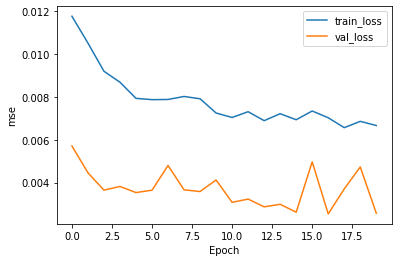

In [18]:
show_loss(train_loss, val_loss, config.loss_function)

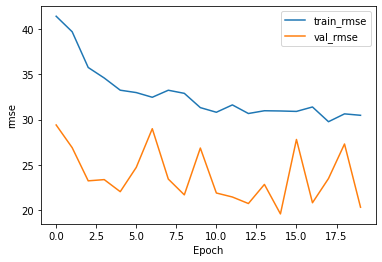

In [19]:
show_rmse(train_rmse, val_rmse)

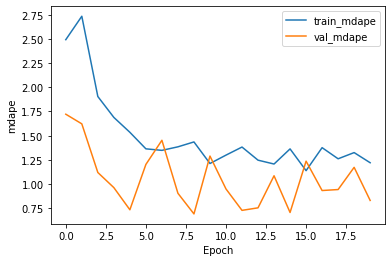

In [20]:
show_mdape(train_mdape, val_mdape)

883.8652140299479 22.025710423787434 0.7543908754984537


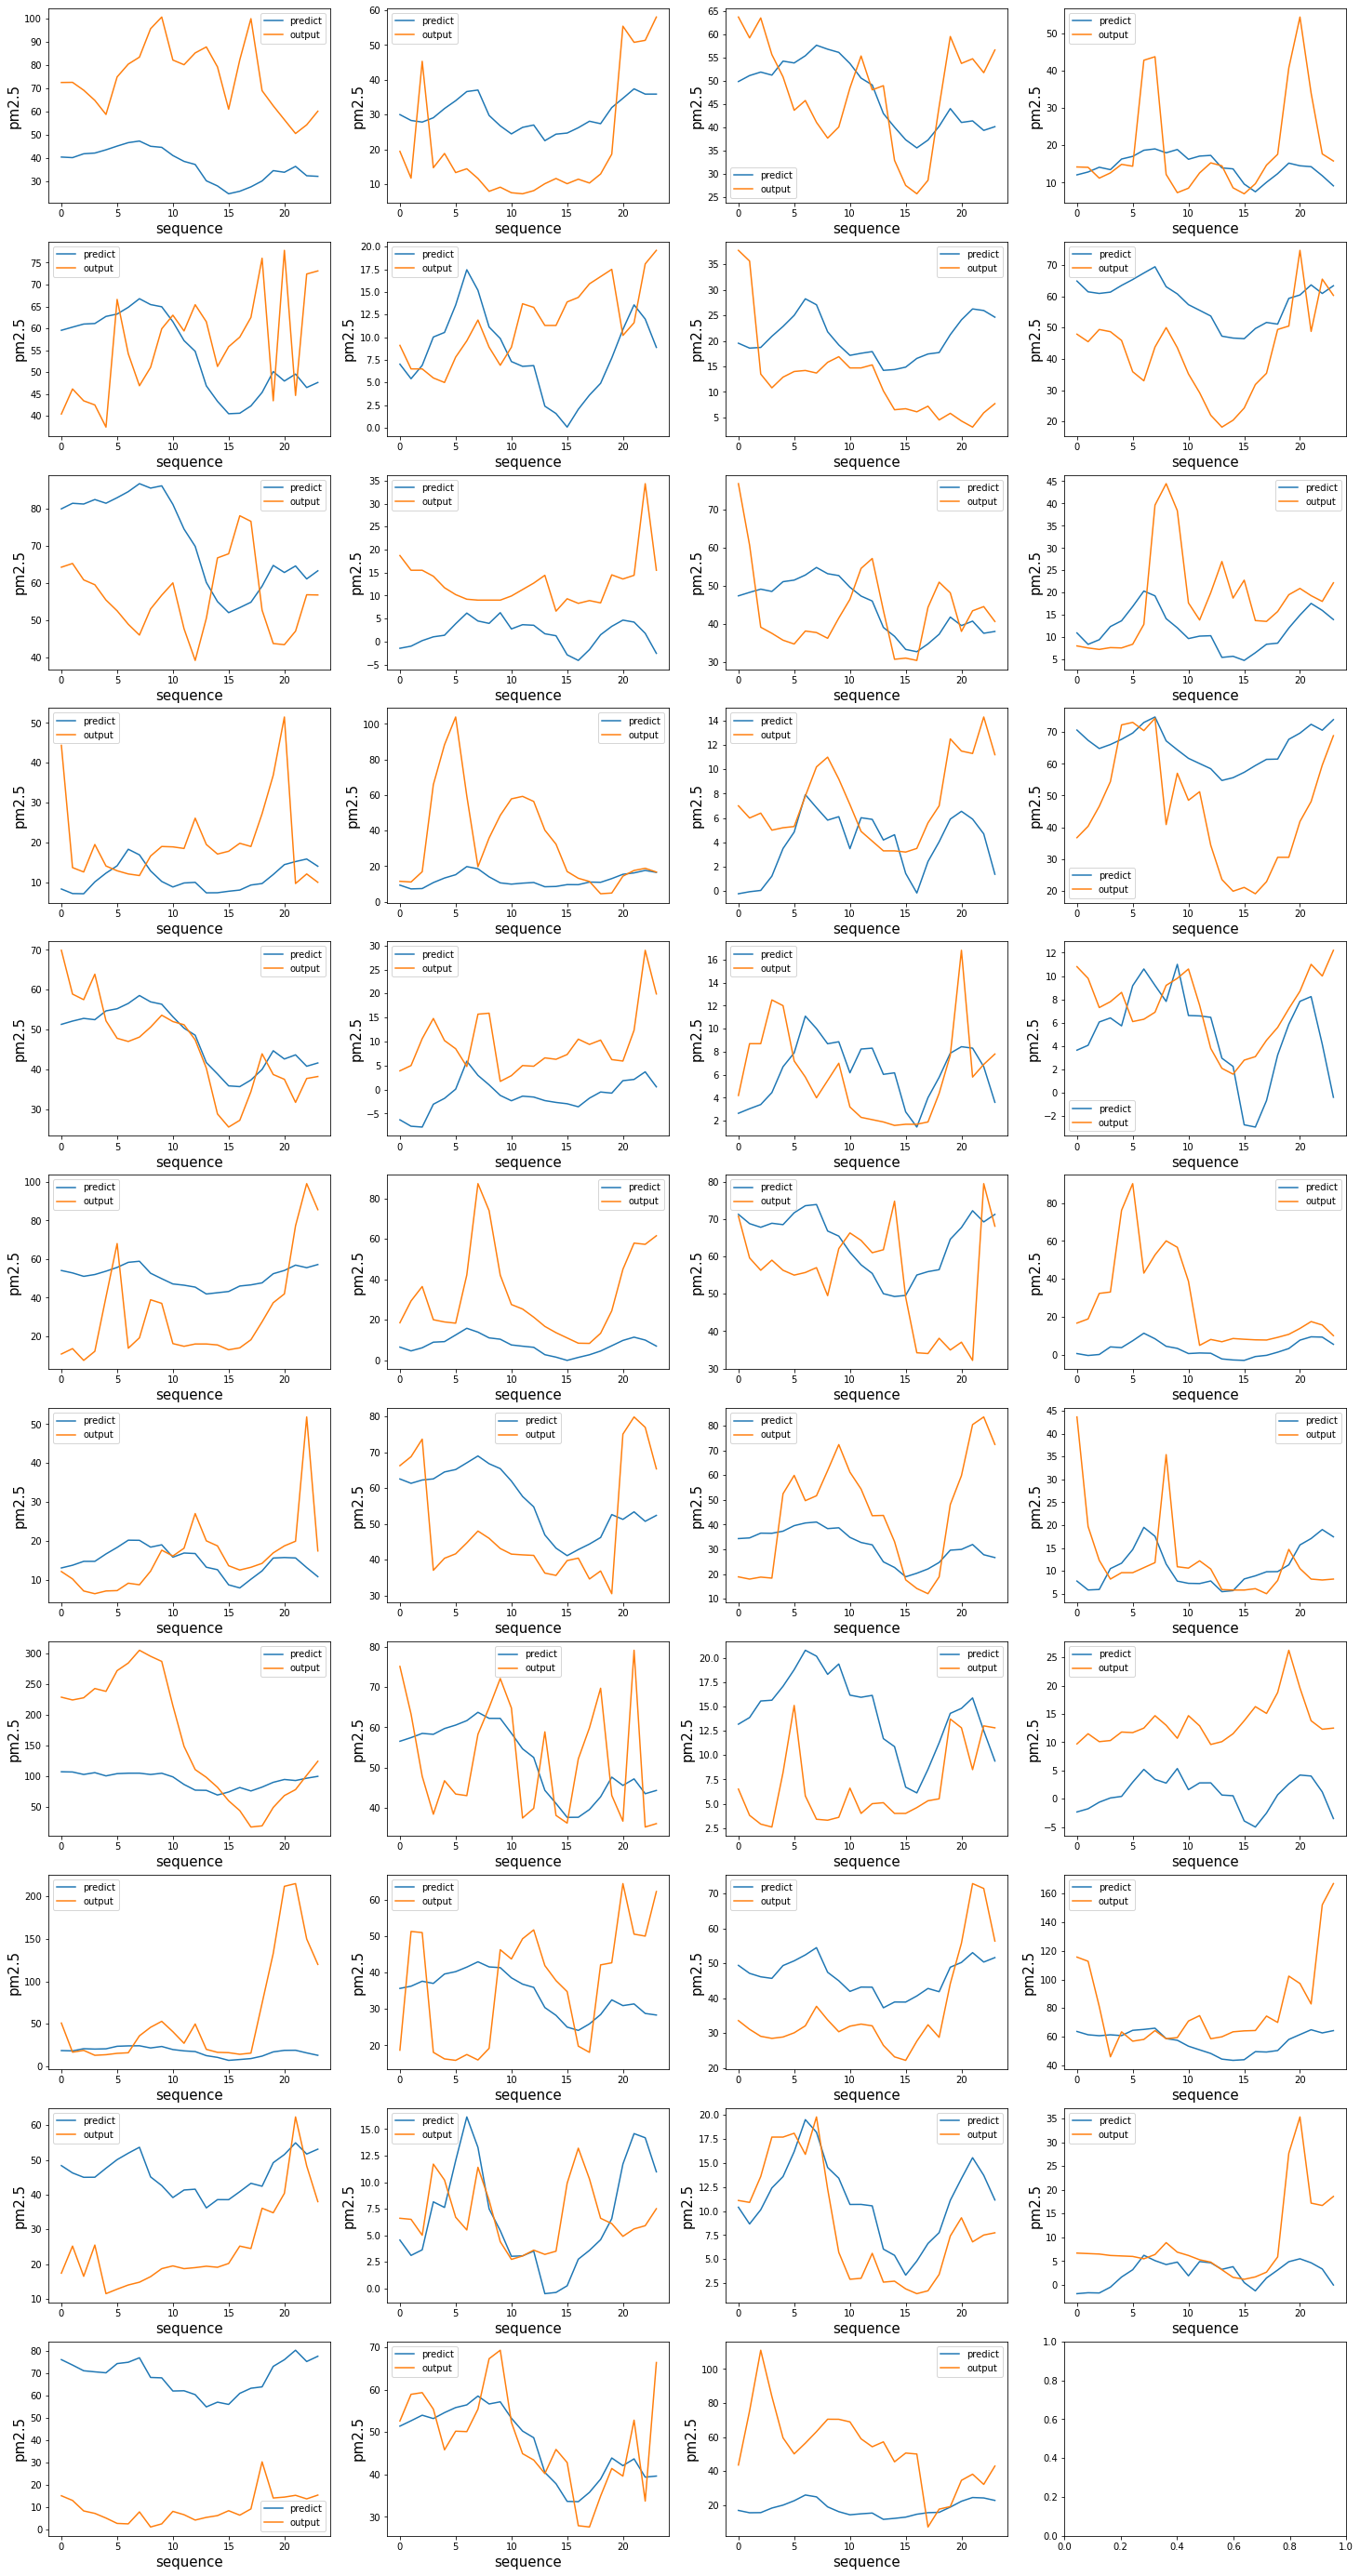

In [21]:
def plot_result(predict, output):
  rows = 11
  cols = 4
  fig, axes = plt.subplots(rows, cols, figsize = (25, 50))
  axes = axes.ravel()

  predict = predict.cpu().detach().numpy()
  output = output.cpu().detach().numpy()
  
  for i in range(predict.shape[0]):
    axes[i].plot(predict[i], label='predict')
    axes[i].plot(output[i], label='output')
    axes[i].legend()
    axes[i].set_xlabel('sequence', fontsize=15)
    axes[i].set_ylabel('pm2.5', fontsize=15)

  
id_val_loader = splitted_data.id_val_loader
loss_fn = nn.MSELoss()
rmse_loss = Metrics(config.std[0], config.mean[0], config.metrics[0])
mdape_loss = Metrics(config.std[0], config.mean[0], config.metrics[1])

error = 0
rmse = 0
mdape = 0
predicts = []
outputs = []
for id in id_val_loader:
  tar_loc =  config.num_tar_locs - 1
  input, output = splitted_data.get_in_out(id, tar_loc, 'val')

  if config.device == 'gpu':
    input = [input[0].to('cuda'), input[1].to('cuda')]
    output = output.to('cuda')
      
  predict = model.predict(input)  
  output = output * config.std[0] + config.mean[0]
  
  loss = loss_fn(predict, output)
  error += loss.item()
  rmse += rmse_loss(predict, output, 'normal').item()
  mdape += mdape_loss(predict, output, 'normal').item()

  predicts.append(predict)
  outputs.append(output)
  
predicts = torch.cat(predicts)
outputs = torch.cat(outputs)

print(error/len(id_val_loader), rmse/len(id_val_loader), mdape/len(id_val_loader))
plot_result(predicts, outputs)

# Predict

In [22]:
def read_locs_output(path_locs: str):
  locs_pd = pd.read_csv(path_locs)
  locs = torch.tensor([locs_pd['longitude'], locs_pd['latitude']])
  return locs.transpose(0, 1)

In [ ]:
save_folder = '/content/prediction'
os.mkdir(save_folder)

dir_path = '/content/drive/Shareddrives/air-team/data_spm/Private/input-full/'
for dir_idx in range(0, 89):
  print('folder {} :'.format(dir_idx + 1))
  
  air_path = dir_path + str(dir_idx + 1) + '/'
  meteo_path = air_path + 'meteo/'
  path_locs_output = air_path + 'location_output.csv'

  raw_data_test = Reading_Raw_Data(air_path, meteo_path) 
  merged_data_test = Merge_Data(raw_data_test, config)

  data, src_locs = merged_data_test.get()
  tar_locs = read_locs_output(path_locs_output)

  data = data.unsqueeze(0)
  distance = compute_distance(src_locs, tar_locs)


  if config.device == 'gpu':
    data = data.to('cuda')
    distance = distance.to('cuda')

  cur_folder = save_folder + '/' + str(dir_idx + 1)
  os.mkdir(cur_folder)
  for tar_loc in range(config.num_tar_locs):
    input = (data.float(), distance[tar_loc].float())
    output = model.predict(input).view(-1)
    output[output < 1] = 1
    df = pd.DataFrame.from_dict({"PM2.5": output.tolist()})
    df.to_csv(os.path.join(cur_folder + '/', f"res_{dir_idx + 1}_{tar_loc + 1}.csv"), index=False)

In [ ]:
!zip -r /content/prediction.zip /content/prediction

In [2]:
!rm -rf prediction